<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## DataFrame Manipulation Lab with Chipotle Data

_Authors: Kiefer Katovich (SF)_

---

This lab is intended to cover a variety of skills for data manipulation in pandas with a challenging dataset.

In addition to python function-writing practice, you will be practicing multiple pandas EDA skills including:
- Data cleaning
- Grouping
- Data summarization and aggregation
- [Pandas split-apply-combine pattern](http://pandas.pydata.org/pandas-docs/stable/groupby.html)
- Basic plotting


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### 1. Load the `chipotle.tsv` and examine the data.

In [2]:
chip_file = '../datasets/chipotle.tsv'

The chipotle data is a .tsv, which means "tab separated value". This is just like a csv but the cells are separated by tabs. There is an argument in read_csv called delimiter, where you can specify the string that separates the tabs:

In [3]:
chip = pd.read_csv(chip_file, delimiter='\t')

In [4]:
chip.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


In [13]:
chip.dtypes

order_id               int64
quantity               int64
item_name             object
choice_description    object
item_price            object
sub_order_id           int64
dtype: object

_The chipotle orders data is messy: the column with ingredients in the order is a list of lists, which will need to be dealt with. This specifically will also be practice with long and wide format data._

#### 2. Create a sub-id for each order-id

We have an identifier for each order already in `order_id`, but no unique identifier for each _sub-order_ within the overall order.

Use grouping and `.apply()` to assign sub-ids for orders.

In [15]:
def add_sub_order_id(df):
    df['sub_order_id'] = np.arange(df.shape[0]) 
    return df # making an array using the df passes shapes

chip = chip.groupby('order_id').apply(add_sub_order_id)
# the previous function will get applied to every unique order id.
# essentually, a dataframe is split from the rest of the df by order_id
# the sub_order_id column is then added to the split which is just an
# array counting the values in that slice from 0.

In [16]:
chip.head(10)

,order_id,quantity,item_name,choice_description,item_price,sub_order_id
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39,0
1,1,1,Izze,[Clementine],$3.39,1
2,1,1,Nantucket Nectar,[Apple],$3.39,2
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39,3
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98,0
5,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",$10.98,0
6,3,1,Side of Chips,NaN,$1.69,1
7,4,1,Steak Burrito,"[Tomatillo Red Chili Salsa, [Fajita Vegetables...",$11.75,0
8,4,1,Steak Soft Tacos,"[Tomatillo Green Chili Salsa, [Pinto Beans, Ch...",$9.25,1
9,5,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Pinto...",$9.25,0


#### 3. Clean up the price column 

We want the price column to be a numeric float value. Currently it is a string (and has the dollar sign in it).

In [17]:
# you will use this action alot with cleaning data.
def price_cleaner(x):
    x = x.replace('$','')
    try:
        return float(x)
    except:
        return np.nan
    
chip.item_price = chip.item_price.map(price_cleaner)

chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0
1,1,1,Izze,[Clementine],3.39,1
2,1,1,Nantucket Nectar,[Apple],3.39,2
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0


#### 4. Make a new categorical column for broader item type

Currently we have many different item types. Make a new column that only has 5 different broad item types. You should have these types in the new column in your DataFrame:

    chips
    drink
    burrito
    taco
    salad
    
(Put the `bowl` items into `burrito` category).

In [18]:
def item_category_maker(x):
    x = x.lower()
    if 'chips' in x:
        return 'chips'
    elif ('burrito' in x) or ('bowl' in x):
        return 'burrito'
    elif 'taco' in x:
        return 'taco'
    elif 'salad' in x:
        return 'salad'
    else:
        return 'drink'
    
chip['broad_type'] = chip.item_name.map(item_category_maker)
print chip.broad_type.unique()
print chip.broad_type.value_counts()

['chips' 'drink' 'burrito' 'taco' 'salad']
burrito    2503
chips      1084
drink       668
taco        345
salad        22
Name: broad_type, dtype: int64


#### 5. Calculate the total price by `order_id` and add as a new as column `order_total_price`.

There are a variety of different ways you can tackle this problem. One way is a grouped apply on the price and then a merge by `order_id` with the total price.

Hints:

- Merging DataFrames with series doesn't work, you need to merge two DataFrames.
- A series object coming out of a groupby with an apply will have the groupby as potentially hierarchical indices. Using `reset_index()` will turn these back into columns and also convert to a DataFrame, which can be used to merge on.

In [20]:
order_prices =  chip.groupby(['order_id']).item_price.apply(np.sum).reset_index()
order_prices.rename(columns={'item_price':'order_total_price'}, inplace=True)
order_prices.head(10)

,order_id,order_total_price
0,1,11.56
1,2,16.98
2,3,12.67
3,4,21.00
4,5,13.70
5,6,17.50
6,7,15.70
7,8,10.88
8,9,10.67
9,10,13.20


In [21]:
chip = chip.merge(order_prices, on='order_id')
print chip.shape
chip.head()

(4622, 8)


,order_id,quantity,item_name,choice_description,item_price,sub_order_id,broad_type,order_total_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0,chips,11.56
1,1,1,Izze,[Clementine],3.39,1,drink,11.56
2,1,1,Nantucket Nectar,[Apple],3.39,2,drink,11.56
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3,chips,11.56
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98


#### 6. Make an `adjusted_item_price` column to account for multiple orders per row.

Some items have multiple orders per row, as indicated by the quantity. Adjust the price to account for the number of orders in a new column.

In [22]:
chip['adj_price'] = chip.item_price/chip.quantity

#### 7. What is the min, max, count, mean and standard deviation of price for each unique item in  `item_name`?

Pivot table works well for this. You can pass multiple aggregation functions into the `aggfunc` argument.

The count won't just be the length of each order's subset - there are multiple orders per row sometimes (evidenced in the quantity column).

In [23]:
# Get the max, min, mean, and std by item name
item_summary_stats = pd.pivot_table(chip, values='adj_price', columns=['item_name'],
                                    aggfunc=[np.max, np.min, np.mean, np.std])

# Deal with multiindex:
item_summary_stats.rename(columns={'amax':'max','amin':'min'}, inplace=True)
item_summary_stats = item_summary_stats.reset_index()

# Get the sum of the quantity column by item name:
item_summary_counts = pd.pivot_table(chip, values='quantity', columns=['item_name'],
                                    aggfunc=[np.sum])
item_summary_counts.rename(columns={'sum':'count'}, inplace=True)
item_summary_counts = item_summary_counts.reset_index()

# Merge the two statistic dataframes together
item_summary = item_summary_stats.merge(item_summary_counts, on='item_name')

print item_summary.shape
item_summary.head(10)

(50, 6)


,item_name,max,min,mean,std,count
0,6 Pack Soft Drink,6.49,6.49,6.490000,0.000000,55
1,Barbacoa Bowl,11.75,8.69,10.187273,1.260994,66
2,Barbacoa Burrito,11.75,8.69,9.832418,1.139519,91
3,Barbacoa Crispy Tacos,11.75,8.99,10.087273,1.270701,12
4,Barbacoa Salad Bowl,11.89,9.39,10.640000,1.317616,10
5,Barbacoa Soft Tacos,11.75,8.99,10.018400,1.191937,25
6,Bottled Water,1.50,1.09,1.431667,0.153272,211
7,Bowl,7.40,7.40,7.400000,0.000000,4
8,Burrito,7.40,7.40,7.400000,0.000000,6
9,Canned Soda,1.09,1.09,1.090000,0.000000,126


#### 8. Plot the mean price of items against the count (popularity).

You have this info in your summary table from the previous question.

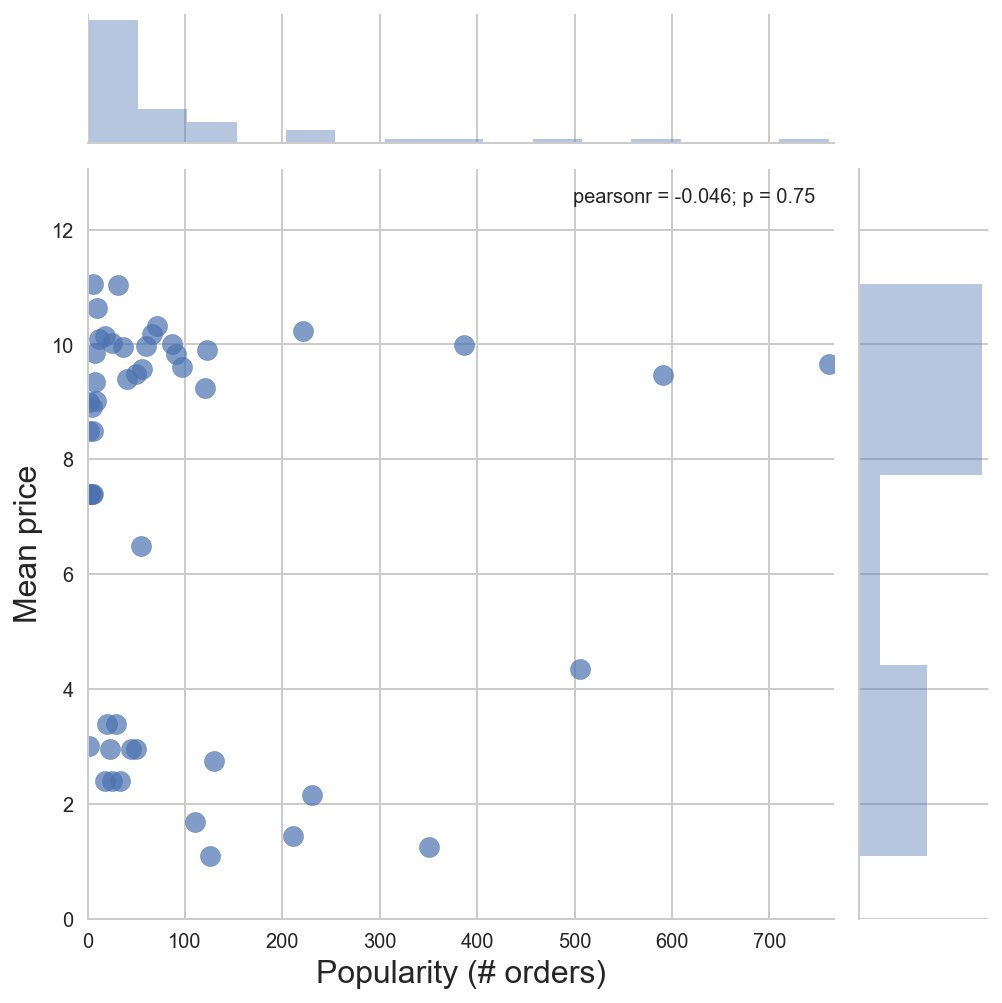

In [24]:
grid = sns.jointplot(x='count', y='mean', data=item_summary,
                     kind='scatter', joint_kws={'s':100, 'alpha':0.7},
                     size=7, xlim=(0, item_summary['count'].max()+5),
                     ylim=(0, item_summary['mean'].max()+2))

grid.ax_joint.set_xlabel('Popularity (# orders)', fontsize=16)
grid.ax_joint.set_ylabel('Mean price', fontsize=16)

plt.show()

#### 9. Plot the max price of items against the count (popularity).

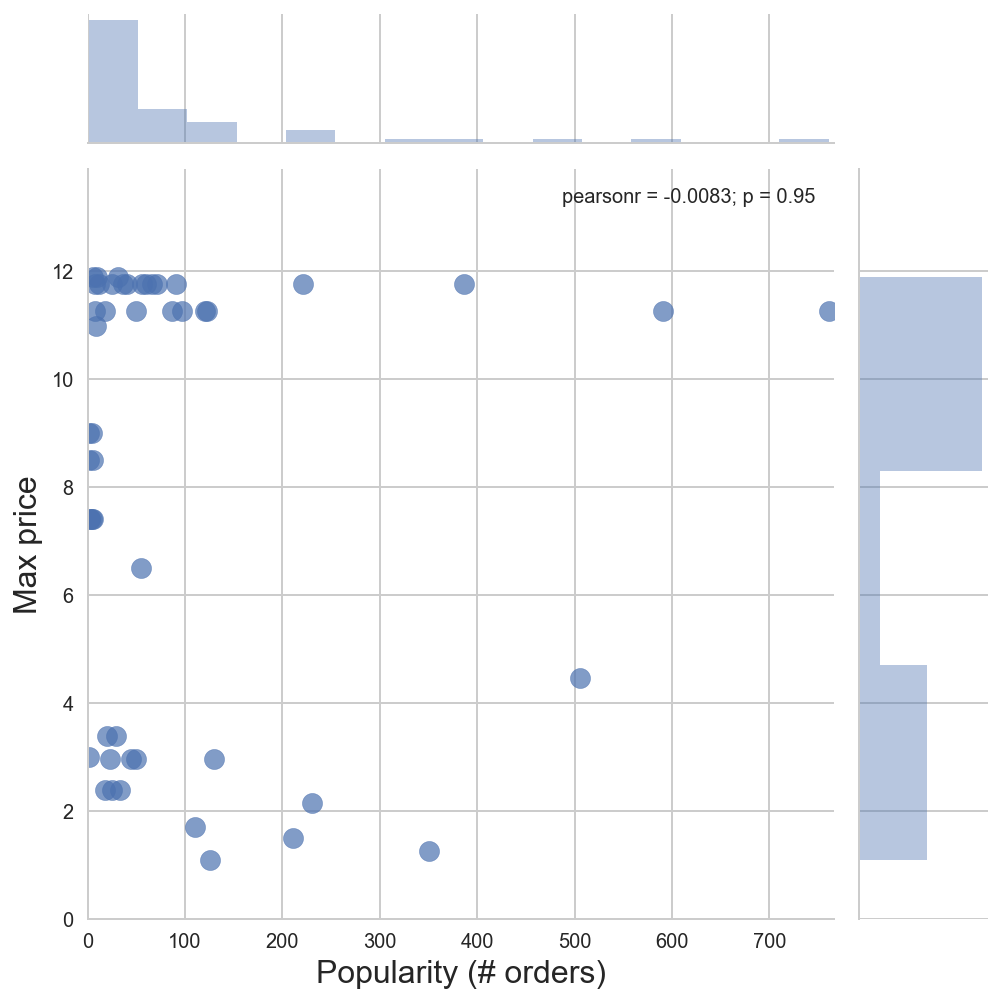

In [25]:
grid = sns.jointplot(x='count', y='max', data=item_summary,
                     kind='scatter', joint_kws={'s':100, 'alpha':0.7},
                     size=7, xlim=(0, item_summary['count'].max()+5),
                     ylim=(0, item_summary['max'].max()+2))

grid.ax_joint.set_xlabel('Popularity (# orders)', fontsize=16)
grid.ax_joint.set_ylabel('Max price', fontsize=16)

plt.show()

### 10. Calculate the mean of adjusted price per broad category.

You can handle these with a single function if you want, or another way if you prefer.

Just FYI, apply functions can have keyword arguments that you pass in when you call the apply chained to the groupby.

for example:

```python
def my_applier(df, my_kwarg='placeholder'):
    df['newcol_'+placeholder] = 1.
    return df
    
data = data.groupby('variable').apply(my_applier, my_kwarg='colsuffix').reset_index(drop=True)
```


In [26]:
def price_mean_by_tier(df, tier_name='tier'):
    price_mean = df.adj_price.mean()
    df[tier_name+'_price_mean'] = price_mean
    return df
   

In [27]:
prices_by_tier = chip[['broad_type','adj_price']]

prices_by_tier = prices_by_tier.groupby('broad_type').apply(price_mean_by_tier, tier_name='broad')
prices_by_tier.reset_index(drop=True)
prices_by_tier = prices_by_tier[['broad_type','broad_price_mean']].drop_duplicates()

prices_by_tier.head()


,broad_type,broad_price_mean
0,chips,3.237408
1,drink,1.843308
4,burrito,9.801454
8,taco,9.504377
250,salad,8.703636


#### 11. Make a barplot of your price mean by the broad type category.


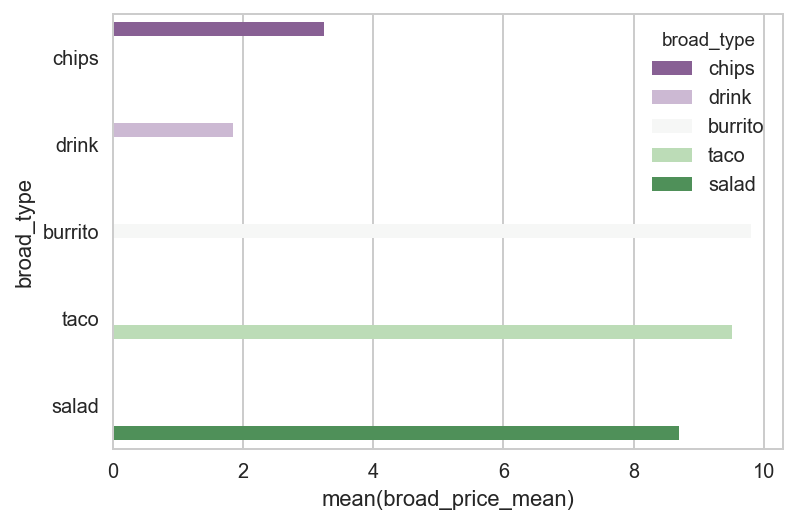

In [28]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()

sns.barplot(x="broad_price_mean", y="broad_type", hue="broad_type", data=prices_by_tier, 
            palette="PRGn", ax=ax, orient='h')

In [29]:
chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id,broad_type,order_total_price,adj_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0,chips,11.56,2.39
1,1,1,Izze,[Clementine],3.39,1,drink,11.56,3.39
2,1,1,Nantucket Nectar,[Apple],3.39,2,drink,11.56,3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3,chips,11.56,2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49


#### 12. [Challenge] Parse the `choice_description` column into two new columns: `order_customizations` and `order_customization_id`

Here is what your inputs and outputs would look like for a hypotheical section of the DataFrame (I'm just showing some of the columns to give you an idea of what the output format will be):

**Input:**

```python
                                  choice_description     item_name  order_id  \
0                                       [Clementine]          Izze         1   
1  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   

   sub_order_id  
0             1  
1             2
```

**Output:**

```python
   order_customization_id order_customizations  \
0                       0           Clementine   
1                       0            Red Salsa   
2                       1          Black Beans   
3                       2            Guacamole   
4                       3           Sour Cream   

                                  choice_description     item_name  order_id  \
0                                       [Clementine]          Izze         1   
1  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
2  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
3  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
4  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   

   sub_order_id  
0             1  
1             2  
2             2  
3             2  
4             2 
```

Hints:

- Remember you can write your own function and pass it into apply. In this case there will be one item per group, since we have to do this parsing for every row, but you may be able to get a solution with `.iterrows()` if you want to try that out.
- Within a function that you are passing into `.apply()`, you can create a _new DataFrame and return that._ This is one of the things that makes apply so powerful, since you can essentially perform any operations you want on a subset of your original DataFrame as long as you return DataFrames/groups that can be recombined.
- *Your output dataframe will be very long as there will be a row for every item in the item_name column.  Expect there to be alot of repeating information betweens rows, but they should not be exactly identical.*

**Note: the function may take awhile to complete. `apply` isn't that efficient with complicated custom operations per row like this.**

In [30]:
def elongate_description_items(df):
    desc = df.choice_description.iloc[0]
    if not type(desc) == str:
        desc = 'None'
        desc_len = 1
    else:
        desc = desc.replace('[','').replace(']','')
        desc = [item.strip() for item in desc.split(',')]
        desc_len = len(desc)
    
    long_order = pd.DataFrame({
            'order_customizations':desc,
            'order_customization_id':np.arange(desc_len)
        })
    
    for col in df.columns:
        long_order[col] = df[col].iloc[0]
        
    return long_order

chip_long = chip.groupby(['order_id','sub_order_id']).apply(elongate_description_items).reset_index(drop=True)

In [31]:
chip_long

,order_customization_id,order_customizations,order_id,quantity,item_name,choice_description,item_price,sub_order_id,broad_type,order_total_price,adj_price
0,0,None,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0,chips,11.56,2.39
1,0,Clementine,1,1,Izze,[Clementine],3.39,1,drink,11.56,3.39
2,0,Apple,1,1,Nantucket Nectar,[Apple],3.39,2,drink,11.56,3.39
3,0,None,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3,chips,11.56,2.39
4,0,Tomatillo-Red Chili Salsa (Hot),2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49
5,1,Black Beans,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49
6,2,Rice,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49
7,3,Cheese,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49
8,4,Sour Cream,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98,8.49
9,0,Fresh Tomato Salsa (Mild),3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",10.98,0,burrito,12.67,10.98
